# Implied distribution

### Setting up

In [2]:

from yahoo_fin import options
from yahoo_fin import stock_info
import yfinance as yf
import pandas as pd
import copy
from datetime import datetime

import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import root_scalar
from matplotlib import pyplot as plt

N_prime = norm.pdf
N = norm.cdf

months_dict = {"January": 1,
               "Febrary": 2,
               "March": 3,
               "April": 4,
               "May": 5,
               "June": 6,
               "July": 7,
               "August": 8,
               "September": 9,
               "October": 10,
               "November": 11,
               "December": 12}


### Loading Data

In [23]:
# Set ticker
ticker = "tsla"

# Get expiration dates
dates = options.get_expiration_dates(ticker)

# Get calls and puts
expiration_date = dates[0]

chain = options.get_options_chain(ticker, expiration_date)
calls_chain = copy.deepcopy(chain["calls"])

# Add expiration date
calls_chain.insert(2, "Expiration Date", [expiration_date] * len(calls_chain))

# Add stock prices
data = yf.download(tickers=ticker, period="1m", interval="1m")
stock_price = data.iloc[0]["Adj Close"]
calls_chain.insert(2, "Stock Closing Price", [stock_price] * len(calls_chain))

c:\Users\pelpi\Documents\Repositories\quantitative-finance\.venv\Lib\site-packages\yahoo_fin\options.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(requests.get(site, headers=headers).text)


[*********************100%%**********************]  1 of 1 completed


In [24]:
calls_chain

,Contract Name,Last Trade Date,Stock Closing Price,Expiration Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,TSLA240405C00100000,2024-04-03 2:36PM EDT,168.389999,"April 5, 2024",100.0,68.21,0.0,0.0,0.0,-,5,167,0.00%
1,TSLA240405C00105000,2024-04-03 2:06PM EDT,168.389999,"April 5, 2024",105.0,62.82,0.0,0.0,0.0,-,1,0,0.00%
2,TSLA240405C00110000,2024-04-03 2:52PM EDT,168.389999,"April 5, 2024",110.0,58.38,0.0,0.0,0.0,-,13,49,0.00%
3,TSLA240405C00115000,2024-04-03 2:08PM EDT,168.389999,"April 5, 2024",115.0,53.17,0.0,0.0,0.0,-,4,15,0.00%
4,TSLA240405C00120000,2024-04-03 2:10PM EDT,168.389999,"April 5, 2024",120.0,48.21,0.0,0.0,0.0,-,7,107,0.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,TSLA240405C00375000,2024-03-28 9:30AM EDT,168.389999,"April 5, 2024",375.0,0.01,0.0,0.0,0.0,-,1,17,50.00%
84,TSLA240405C00380000,2024-03-28 9:30AM EDT,168.389999,"April 5, 2024",380.0,0.01,0.0,0.0,0.0,-,1,5,50.00%
85,TSLA240405C00385000,2024-04-03 12:51PM EDT,168.389999,"April 5, 2024",385.0,0.01,0.0,0.0,0.0,-,3,3,50.00%
86,TSLA240405C00390000,2024-04-01 10:15AM EDT,168.389999,"April 5, 2024",390.0,0.01,0.0,0.0,0.0,-,4,77,50.00%


### Functions

In [25]:
def black_scholes_call(S, K, tau, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param tau: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    '''

    if sigma <0.01:
        return 0

    ### standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    call = S * N(d1) -  N(d2)* K * np.exp(-r * tau)
    return call

def vega_call(S, K, tau, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''
    ### calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * tau) / sigma * np.sqrt(tau)

    vega = S  * np.sqrt(tau) * N_prime(d1)
    return vega

def implied_volatility_call(C, S, K, tau, r, tol=0.1, max_iterations=100, printing=True):
    '''

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''

    ### assigning initial volatility estimate for input in Newton_rap procedure
    sigma = C / S * np.sqrt(2*math.pi / tau)

    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = black_scholes_call(S, K, tau, r, sigma) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:

            if printing:
                print(f'found on {i}th iteration')
                print(f'difference is equal to {diff}')

            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / vega_call(S, K, tau, r, sigma)

    return sigma

def implied_volatility_call_solver(C, S, K, tau, r, tol=0.01, max_iterations=10000, printing=True):
    '''

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''

    def f(sigma):

        return black_scholes_call(S, K, tau, r, sigma) - C

    sigma0 = C / S * np.sqrt(2*math.pi / tau)

    sol = root_scalar(f, method='brenth', x0=sigma0, xtol=tol, maxiter=max_iterations, bracket=[-0.1, 100])
    print(f"Strike: {K}, Price: {C}, BS-price: {black_scholes_call(S, K, tau, r, sol.root)}, Vol: {sol.root}")

    return sol.root

def get_implied_vol(row: pd.core.series.Series, r: float = 0.1, printing: bool = False):

    # Use the midpoint as price, if bid and ask not available use the last traded price
    if row["Bid"] == 0 or row["ask"] == 0:
        option_price = row["Last Price"]
    else:
        option_price = (row["Bid"] + row["Ask"]) / 2

    strike = row["Strike"]

    stock_price = row["Stock Closing Price"]

    # last_traded_date = row["Last Trade Date"].rsplit(' ', 1)[0]
    # time_format = "%Y-%m-%d %I:%M%p"
    # last_traded_date_dt = datetime.strptime(last_traded_date, time_format)

    expiration_date = row["Expiration Date"]
    time_format = "%B %d, %Y"
    expiration_date_dt = datetime.strptime(expiration_date, time_format)

    time_to_maturity = expiration_date_dt - datetime.now()
    time_to_maturity_years = time_to_maturity.total_seconds() / (365 * 24 * 60 * 60)

    return implied_volatility_call(C=option_price, S=stock_price, K=strike, tau=time_to_maturity_years, r=r, printing = printing)

def get_implied_volatilities_per_strike(df: pd.core.frame.DataFrame):

    strike_vol_dict = {}

    for _, row in df.iterrows():
        implied_vol = get_implied_vol(row)
        strike_vol_dict[row["Strike"]] = implied_vol

    return strike_vol_dict

### Get implied volatilties

In [26]:
strike_vol_dict = get_implied_volatilities_per_strike(calls_chain)

68.21 168.38999938964844 0.0011563664700976663
62.82 168.38999938964844 0.0011563657114726027
58.38 168.38999938964844 0.0011563645622146119
53.17 168.38999938964844 0.0011563642290081178
48.21 168.38999938964844 0.0011563635501014712
40.55 168.38999938964844 0.001156362908834348
40.9 168.38999938964844 0.0011563622970890413
38.23 168.38999938964844 0.0011563616906075597
40.85 168.38999938964844 0.001156360979230086
32.68 168.38999938964844 0.0011563609472983257
36.05 168.38999938964844 0.00115636040547311
33.67 168.38999938964844 0.0011563603735413495
28.63 168.38999938964844 0.0011563603090436326
27.5 168.38999938964844 0.0011563597248541349
28.1 168.38999938964844 0.0011563591192605277


C:\Users\pelpi\AppData\Local\Temp\ipykernel_25928\1003746091.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = sigma - diff / vega_call(S, K, tau, r, sigma)
C:\Users\pelpi\AppData\Local\Temp\ipykernel_25928\1003746091.py:33: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * tau) / sigma * np.sqrt(tau)


25.8 168.38999938964844 0.0011563583785197868
23.02 168.38999938964844 0.0011563577078576865
25.2 168.38999938964844 0.001156357120877727
20.7 168.38999938964844 0.0011563564509449518
22.7 168.38999938964844 0.0011563559072805684
20.1 168.38999938964844 0.0011563553011478946
20.5 168.38999938964844 0.0011563547263127854
20.33 168.38999938964844 0.0011563541197044647
18.61 168.38999938964844 0.0011563539928652969
18.38 168.38999938964844 0.0011563533864789447
16.35 168.38999938964844 0.0011563532886859462
13.43 168.38999938964844 0.0011563532251078132
11.05 168.38999938964844 0.0011563531614028413
8.7 168.38999938964844 0.0011563531299467276
6.55 168.38999938964844 0.0011563530980466768
4.5 168.38999938964844 0.001156353066336885
2.91 168.38999938964844 0.001156353034627093
1.64 168.38999938964844 0.001156353034627093
0.82 168.38999938964844 0.001156353002885591
0.37 168.38999938964844 0.001156352971175799
0.16 168.38999938964844 0.0011563529388318112
0.08 168.38999938964844 0.001156352

### Plot implied volatilities

<function matplotlib.pyplot.show(close=None, block=None)>

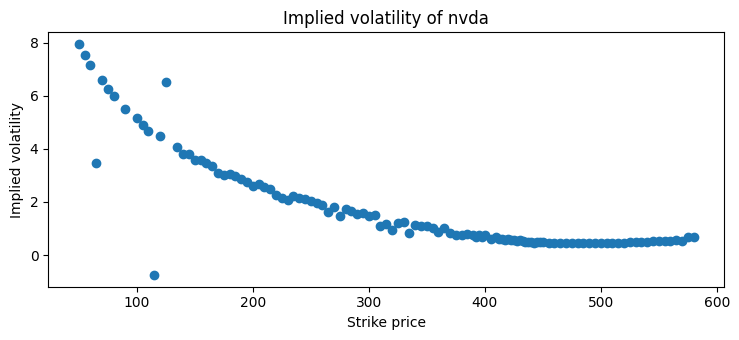

In [128]:
strikes = strike_vol_dict.keys()
vols = strike_vol_dict.values()

plt.plot(strikes, vols, marker='o', linestyle='')

plt.xlabel("Strike price")
plt.ylabel("Implied volatility")
plt.title(f"Implied volatility of {ticker}")

plt.show

### Generate price using stock distribution

In [205]:
# Basic idea: Price = discounted expected pay-off

from typing import Callable
import scipy.integrate as integrate

class pdf:

    def __init__(self, func: Callable):
        self.func = func

        if not self.correct_area():
            print("Beware! This function does not have an area close to 1")

    def correct_area(self, tol = 0.01) -> bool:
        area = integrate.quad(lambda s: self.func(s), -np.inf, np.inf)[0]
        print(f"area: {area}")

        if abs(1-area) > tol:
            return False
        else:
            return True

    def __call__(self, s):
        return self.func(s)

def get_derivative_price(r: float, tau:float, payoff: Callable, strike: float, stock_pdf: pdf):

    if not stock_pdf.correct_area():
        raise Exception("The provided stock_pdf does not have the correct area (close to 1)")

    integral = integrate.quad(lambda s: payoff(s, strike)*stock_pdf(s), -np.inf, np.inf)[0]

    return math.exp(r*tau)*integral

In [221]:
def linear(x):
    return x

def european_call_payoff(S, K):
    return max(0, S - K)

linear_pdf = pdf(linear)
normal_pdf = pdf(N_prime)

from scipy.stats import lognorm

log_normal = pdf(lognorm(6,6).pdf)

get_derivative_price(r=0.02, tau=1, payoff=european_call_payoff, strike = 7, stock_pdf=log_normal)

area: 0.0
Beware! This function does not have an area close to 1
area: 0.9999999999999998
area: 1.0033974491991682


C:\Users\pelpi\AppData\Local\Temp\ipykernel_23304\709428012.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area = integrate.quad(lambda s: self.func(s), -np.inf, np.inf)[0]


area: 1.0033974491991682


C:\Users\pelpi\AppData\Local\Temp\ipykernel_23304\709428012.py:31: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(lambda s: payoff(s, strike)*stock_pdf(s), -np.inf, np.inf)[0]


-0.5151104298419182

In [214]:
# Goal minimize variance of parameters that are implied by the option price
# Issue: how to deal with distributions that have multiple parameters

# Algorithm flow:

# (1): We have data of option prices, strikes, maturities, stock price (maybe not necessary?)
# (2): We have a potential distribution class, but do not know the parameter(s)
# (3): Estimate the parameter(s) for each option (or for a n options for n parameters, on rolling basis?)
        # Only works if option price is montonic in parameter??
# (4): Calculate the variance of the parameters over each (set of) option(s)
        # No longer for each strike, but maybe doesn't matter since goals is minimizing difference in parameter estimates?
# (5): Repeat for different distribution classes, choose one with lowest variance in parameters

# Apparently there is quite some literature on this: for European Calls the implied distribution is just equal to the second derivative of the Call price wrt the strike price...
# The algorithm above could be more flexible and doesn't require inter- and extrapolation.

1.0

In [38]:
def get_simple(x):
    S = 100
    K = 900
    tau = 1
    r=0.03

    return implied_volatility_call(C=x, S=S, K=K, tau=tau, r=r)


# x = np.linspace(-10,10,100)

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# plt.plot(x, get_simple(x), color='red')
# plt.show()

get_simple(0.01)

-0.01
found on 0th iteration
difference is equal to -0.01


0.0002506628274631